In [1]:
# Suprime los warnings
import warnings
warnings.filterwarnings('ignore')

# importing the packages
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
import sklearn.exceptions
from pylab import rcParams
#import plot_functions as pf
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics, preprocessing, svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("C:/Users/56957/Desktop/Python/dataset_Caso_1.csv",sep=",")
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,target
0,50.1341,-326.0000,SAT,MZBER,0,0,6,-6.5,0
1,50.1341,-326.0000,SAT,MZBER,0,0,6,-4.5,0
2,124.3276,-275.1935,LCV,MZBER,0,0,3,-2.5,0
3,50.1341,-326.0000,SAT,MZBER,0,0,3,-4.5,0
4,85.3905,-298.8632,XJB,MZBER,0,0,5,-4.5,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      2000 non-null   float64
 1   x2      2000 non-null   float64
 2   x3      2000 non-null   object 
 3   x4      2000 non-null   object 
 4   x5      2000 non-null   int64  
 5   x6      2000 non-null   int64  
 6   x7      2000 non-null   int64  
 7   x8      2000 non-null   float64
 8   target  2000 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 140.8+ KB


In [4]:
df["target"].value_counts()

0    1978
1      22
Name: target, dtype: int64

Como vemos, los datos están sesgados, es decir, el número de muestras para la clase 1 es inferior al 0,5 % de las muestras de la clase 0. En este caso, los algoritmos de aprendizaje automático no predicen correctamente los casos, por lo que habrá que utilizar métodos para manejar el desequilibrio de los datos.

**Análisis Exploratorio**

In [5]:
## Detección valores missing en data
total_missing_df = df.isnull().sum().sort_values(ascending=False)
percent_missing_df = round(
    (df.isnull().sum().sort_values(ascending=False)/len(df))*100, 2)
pd.concat([total_missing_df, percent_missing_df],
          axis=1, keys=['Total', 'Porcentaje'])

,Total,Porcentaje
x1,0,0.0
x2,0,0.0
x3,0,0.0
x4,0,0.0
x5,0,0.0
x6,0,0.0
x7,0,0.0
x8,0,0.0
target,0,0.0


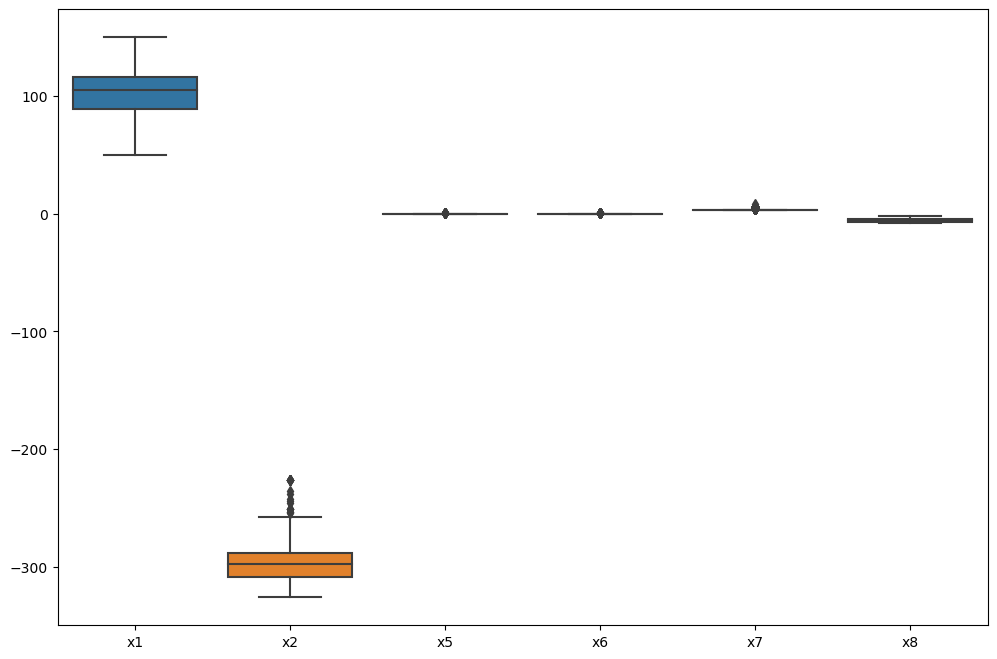

In [6]:
##Detección de outliers
df_t=df.iloc[:,~df.columns.isin(['target','x3','x4'])]
fig = plt.figure(figsize=(12, 8))
sns.boxplot(data=df_t)
plt.show()

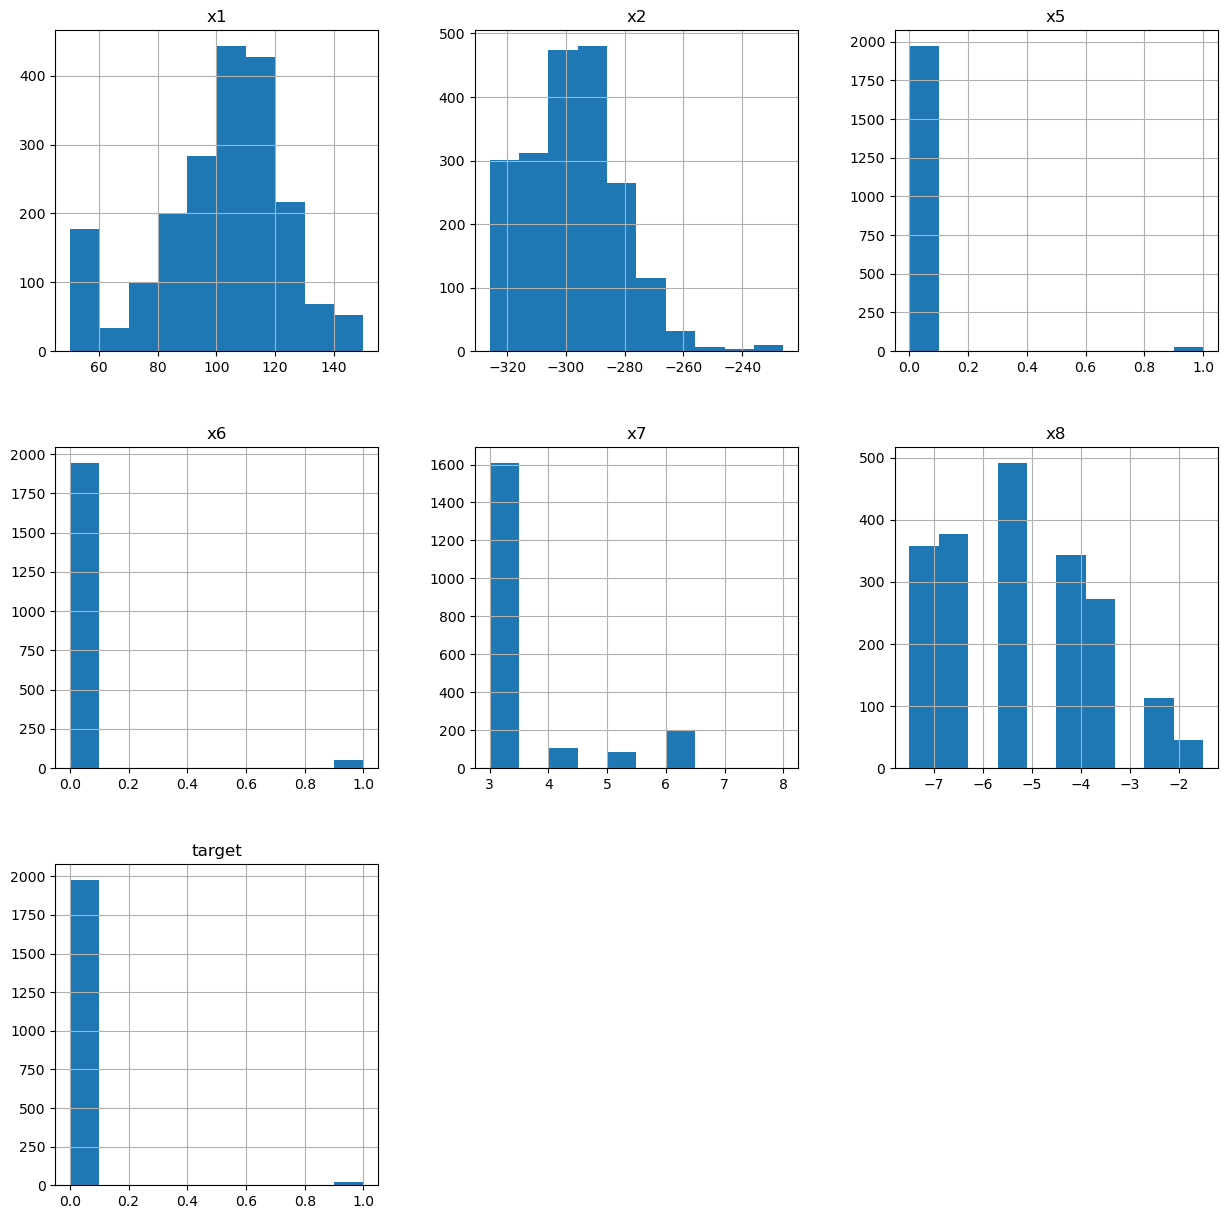

In [7]:
#visualización de las variables 
df.hist(figsize = (15, 15))
plt.show()

Text(0.5, 0.98, 'Correlaciones')

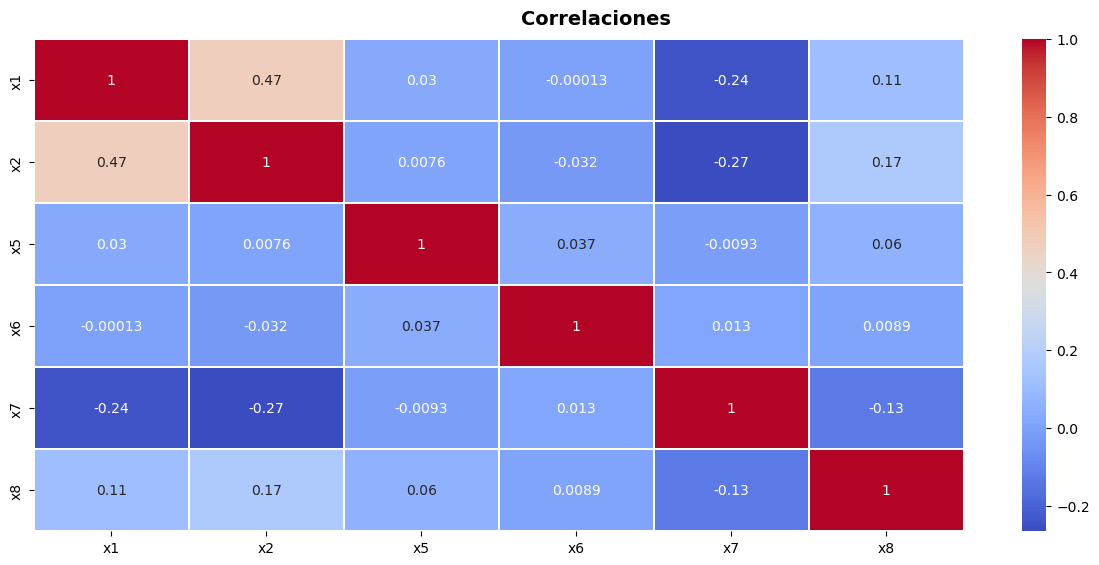

In [8]:
# Correlaciones
fig, (ax) = plt.subplots(1, 1, figsize=(15,6))
corr =df.iloc[:,~df.columns.isin(['target','x3','x4'])].corr()
sns.heatmap(corr,ax = ax,cmap='coolwarm',annot=True,linewidths=0.05)
fig.subplots_adjust(top=0.93)
fig.suptitle('Correlaciones', fontsize=14,fontweight='bold')

In [9]:
df.corr()['target'].abs().sort_values(ascending=False)

target    1.000000
x5        0.333312
x6        0.189463
x1        0.030486
x8        0.023078
x2        0.019244
x7        0.011384
Name: target, dtype: float64

**Preparación para los Modelos**

Es importante estandarizar las variables para que los modelos se ajusten correctamente.

In [10]:
# Convertir el tipo de variable 
df['x3'] = df['x3'].astype('object')
df['x3'].dtype

df['x4'] = df['x4'].astype('object')
df['x4'].dtype

dtype('O')

In [11]:
#escalamiento variables cuantitativas
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()

x1_scale = scaler.fit(df['x1'].values.reshape(-1, 1))
df['x1_scaled'] = scaler.fit_transform(
df['x1'].values.reshape(-1, 1), x1_scale)

x2_scale = scaler.fit(df['x2'].values.reshape(-1, 1))
df['x2_scaled'] = scaler.fit_transform(
df['x2'].values.reshape(-1, 1), x2_scale)

x5_scale = scaler.fit(df['x5'].values.reshape(-1, 1))
df['x5_scaled'] = scaler.fit_transform(
df['x5'].values.reshape(-1, 1), x5_scale)

x6_scale = scaler.fit(df['x6'].values.reshape(-1, 1))
df['x6_scaled'] = scaler.fit_transform(
df['x6'].values.reshape(-1, 1), x6_scale)

x7_scale = scaler.fit(df['x7'].values.reshape(-1, 1))
df['x7_scaled'] = scaler.fit_transform(
df['x7'].values.reshape(-1, 1), x7_scale)

x8_scale = scaler.fit(df['x8'].values.reshape(-1, 1))
df['x8_scaled'] = scaler.fit_transform(
df['x8'].values.reshape(-1, 1), x8_scale)

In [12]:
#eliminar variables duplicadas
df=df.drop(['x1','x2', 'x5','x6' ,'x7', 'x8'], axis=1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   x3         2000 non-null   object 
 1   x4         2000 non-null   object 
 2   target     2000 non-null   int64  
 3   x1_scaled  2000 non-null   float64
 4   x2_scaled  2000 non-null   float64
 5   x5_scaled  2000 non-null   float64
 6   x6_scaled  2000 non-null   float64
 7   x7_scaled  2000 non-null   float64
 8   x8_scaled  2000 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 140.8+ KB


En el caso de las variables categóricas se utilizará el método One Hot Encoding para otorgar mayor precisión para el modelo.

In [14]:
pd.value_counts(df["x3"])

LCV    926
SAT    715
XJB    280
QKP     79
Name: x3, dtype: int64

In [15]:
pd.value_counts(df["x4"])

MZBER    1918
YEQA       41
PQKE       36
ZUQF        5
Name: x4, dtype: int64

In [16]:
# Lista de variables categoricas
categorical_features =[feature for feature in df.columns if df[feature].dtypes == 'O']
categorical_features

['x3', 'x4']

In [17]:
#Función para covertir variables categoricas a one_hot_encodin

def category_onehot_multcols(data,multcolumns):
    df_final = data
    i=0
    for fields in multcolumns:
        print(fields)
        df1=pd.get_dummies(df[fields],drop_first=True)
        df.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:           
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1             
    df_final=pd.concat([df,df_final],axis=1)
    return df_final

    # applying the one hot encoding
df = category_onehot_multcols(df, categorical_features)

x3
x4


In [18]:
# Dropea variables duplicadas
df =df.loc[:,~df.columns.duplicated()]
df.shape

(2000, 13)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   target     2000 non-null   int64  
 1   x1_scaled  2000 non-null   float64
 2   x2_scaled  2000 non-null   float64
 3   x5_scaled  2000 non-null   float64
 4   x6_scaled  2000 non-null   float64
 5   x7_scaled  2000 non-null   float64
 6   x8_scaled  2000 non-null   float64
 7   QKP        2000 non-null   uint8  
 8   SAT        2000 non-null   uint8  
 9   XJB        2000 non-null   uint8  
 10  PQKE       2000 non-null   uint8  
 11  YEQA       2000 non-null   uint8  
 12  ZUQF       2000 non-null   uint8  
dtypes: float64(6), int64(1), uint8(6)
memory usage: 121.2 KB


**Entrenamiento del Modelo**

El Modelo escogido será la Regresión Logística, existen otros métodos de clasificación como Random Forest, SVM, RNA, entre otros, pero dada la baja dimensión de observaciones, estos son más propensos al sobreajuste, lo que entregaría unas estimaciones sesgadas.

Inicialmente se ejecutan los modelos con los datos desbalanceados sin aplicar ninguna técnica de sobremuestreo, analizando las métricas de precisión y recall (sensibilidad) ya que como se evidenciará en los resultados, la métrica de accuracy se puede ver sesgada por la clase mayoritaria reflejando buenos resultados que no siempre son reales.

In [20]:
y = df["target"]
x = df.drop(["target"],axis=1)
print(np.shape(y))
print(np.shape(x))

(2000,)
(2000, 12)


In [21]:
##Dividimos la data en entrenamiento y test 80% y 20%
from sklearn.model_selection import train_test_split
df_Train, df_Test, Y_train, Y_test = train_test_split(x,y,test_size=0.2, random_state = 123)
print(np.shape(df_Train))
print(np.shape(df_Test))
print(np.shape(Y_train))
print(np.shape(Y_test))

(1600, 12)
(400, 12)
(1600,)
(400,)


In [22]:
# Regresión Logística desbalanceada
model_LR = LogisticRegression(random_state=137)
model_LR.fit(df_Train,Y_train)
y_pred = model_LR.predict(df_Test)

In [23]:
#Evaluando los modelos

def print_eval(y_pred,model):
    print("Training Accuracy: ",model.score(df_Train, Y_train))
    print("Testing Accuracy: ", model.score(df_Test, Y_test))
    cm = confusion_matrix(Y_test, y_pred)
    print(cm)
    print(classification_report(Y_test,y_pred))

In [24]:
# Evaluación Regresión logística con muestras desbalanceadas

print_eval(y_pred,model_LR)

Training Accuracy:  0.98875
Testing Accuracy:  0.995
[[397   0]
 [  2   1]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       397
           1       1.00      0.33      0.50         3

    accuracy                           0.99       400
   macro avg       1.00      0.67      0.75       400
weighted avg       1.00      0.99      0.99       400



Se puede apreciar que el modelo esta sesgado, sobreajustado con un recall ínfimo. Para mejorar el modelo se utilizarán las técnicas de Oversampling y SMOTE. Debido a la baja dimensión de la clase 1, no se utilizará Undersampling ni Nearmiss.

Antes de balancear la muestra se verificará si existe Colinealidad entre las variables.

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_scores=pd.DataFrame()
vif_scores["Feature"]=df.columns

In [26]:
vif_scores["Vif Scores"]=[variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
display(vif_scores)

,Feature,Vif Scores
0,target,1.176295
1,x1_scaled,1.351996
2,x2_scaled,1.393785
3,x5_scaled,1.159081
4,x6_scaled,1.053977
5,x7_scaled,1.122070
6,x8_scaled,1.151786
7,QKP,1.097945
8,SAT,1.065184
9,XJB,1.073111


**OVERSAMPLING**

Este método no produce pérdida de información pero si es propenso al sobreajuste ya que replica los eventos de la clase minoritaria

In [27]:
#Agrega la variable dependiente al train dataset
print(Y_train.shape,df_Train.shape)
df_train = pd.concat([df_Train,Y_train],axis = 1)
df_train.shape

(1600,) (1600, 12)


(1600, 13)

In [28]:
# contador de clase
count_class_0, count_class_1 = df_train.target.value_counts()
print(count_class_0, count_class_1)
# Divide por clase
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]
print(df_class_0.shape,df_class_1.shape)

1581 19
(1581, 13) (19, 13)


In [29]:
# Oversample 
df_class_1_over = df_class_1.sample(count_class_0,replace=True,random_state=12)
df_train_over_sample = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')

print(df_train_over_sample.target.value_counts())

Random over-sampling:
0    1581
1    1581
Name: target, dtype: int64


In [30]:
X = df_train_over_sample.drop('target',axis='columns')
y = df_train_over_sample['target']

In [31]:
model_LR_over_sample = LogisticRegression(random_state=1)
model_LR_over_sample.fit(X,y)
y_pred = model_LR_over_sample.predict(df_Test)
print_eval(y_pred,model_LR_over_sample)
roc_auc_score(Y_test, y_pred)

Training Accuracy:  0.8925
Testing Accuracy:  0.895
[[356  41]
 [  1   2]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.94       397
           1       0.05      0.67      0.09         3

    accuracy                           0.90       400
   macro avg       0.52      0.78      0.52       400
weighted avg       0.99      0.90      0.94       400



0.781696053736356

**MUESTREO SMOTE**

El algoritmo SMOTE funciona en 4 sencillos pasos:

Elija una clase minoritaria como vector de entrada.

Encuentra sus k vecinos más cercanos (k_neighbors se especifica como un argumento en la función SMOTE(), el valor predeterminado es 5).

Elija uno de estos vecinos y coloque un punto sintético en cualquier lugar de la línea que une el punto en consideración y su vecino elegido.

Repita los pasos hasta que los datos estén equilibrados.

Ventajas

Mitiga el problema del sobreajuste causado por el sobremuestreo aleatorio, ya que se generan ejemplos sintéticos en lugar de la replicación de instancias. Sin pérdida de información útil.

Desventajas

Al generar ejemplos sintéticos, SMOTE no tiene en cuenta los ejemplos vecinos de otras clases. Esto puede dar como resultado un aumento en la superposición de clases y puede introducir ruido adicional. SMOTE no es muy efectivo para datos de alta dimensión

In [32]:
print(df_Train.shape,df_Test.shape)

(1600, 12) (400, 12)


In [33]:
# smote
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy = 'minority',random_state=1)
X_sm, y_sm = smote.fit_resample(df_Train, Y_train)
y_sm.value_counts()

0    1581
1    1581
Name: target, dtype: int64

In [34]:
model_LR_smote = LogisticRegression(random_state=137)
model_LR_smote.fit(X_sm,y_sm)
y_pred = model_LR_smote.predict(df_Test)
print_eval(y_pred,model_LR_smote)
roc_auc_score(Y_test, y_pred)

Training Accuracy:  0.836875
Testing Accuracy:  0.7925
[[315  82]
 [  1   2]]
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       397
           1       0.02      0.67      0.05         3

    accuracy                           0.79       400
   macro avg       0.51      0.73      0.46       400
weighted avg       0.99      0.79      0.88       400



0.7300587741393786

**Red Neuronal Artificial (RNA)**

In [35]:
pipe = Pipeline([('modelo', MLPClassifier(activation='logistic',solver = 'lbfgs',random_state=123, max_iter= 1000))])
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'modelo__hidden_layer_sizes': [(10), (20), (10, 10)],
    'modelo__alpha': np.logspace(-3, 3, 10),
    'modelo__learning_rate_init': [0.001, 0.01],
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = df_Train, y = Y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

,param_modelo__learning_rate_init,param_modelo__hidden_layer_sizes,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.001,10,0.464159,-0.011250,0.001531,-0.011094,0.000585
44,0.01,10,0.464159,-0.011250,0.001531,-0.011094,0.000585
33,0.01,"(10, 10)",2.154435,-0.011875,0.001250,-0.011875,0.000313
23,0.01,20,215.443469,-0.011875,0.001250,-0.011875,0.000313
1,0.01,20,10.0,-0.011875,0.001250,-0.011875,0.000313
27,0.001,20,215.443469,-0.011875,0.001250,-0.011875,0.000313
28,0.01,"(10, 10)",0.464159,-0.011875,0.001250,-0.011094,0.000585
29,0.01,20,1000.0,-0.011875,0.001250,-0.011875,0.000313
30,0.01,10,10.0,-0.011875,0.001250,-0.011875,0.000313
31,0.001,10,215.443469,-0.011875,0.001250,-0.011875,0.000313


In [36]:
from sklearn.metrics import mean_squared_error
# Error de test
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = df_Test)
rmse = mean_squared_error(
        y_true = Y_test,
        y_pred = predicciones,
        squared = False
       )
print('Error de test (rmse): ', rmse)

Error de test (rmse):  0.07071067811865475


In [37]:
modelo_final['modelo'].get_params()

{'activation': 'logistic',
 'alpha': 0.46415888336127775,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 10,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 123,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [38]:
y_pred = modelo_final.predict(df_Test)
print_eval(y_pred,modelo_final)
roc_auc_score(Y_test, y_pred)

Training Accuracy:  0.98875
Testing Accuracy:  0.995
[[397   0]
 [  2   1]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       397
           1       1.00      0.33      0.50         3

    accuracy                           0.99       400
   macro avg       1.00      0.67      0.75       400
weighted avg       1.00      0.99      0.99       400



0.6666666666666666

Oversampling RNA

In [39]:
pipe = Pipeline([('modelo', MLPClassifier(activation='logistic',solver = 'lbfgs',random_state=123, max_iter= 1000))])
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'modelo__hidden_layer_sizes': [(10), (20), (10, 10)],
    'modelo__alpha': np.logspace(-3, 3, 10),
    'modelo__learning_rate_init': [0.001, 0.01],
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X, y = y)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

,param_modelo__learning_rate_init,param_modelo__hidden_layer_sizes,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
47,0.01,20,0.004642,-0.008221,0.003922,-0.000079,0.000158
19,0.001,20,0.004642,-0.008221,0.003922,-0.000079,0.000158
37,0.01,20,0.001,-0.008539,0.002368,-0.001265,0.000767
14,0.01,"(10, 10)",0.004642,-0.010120,0.005708,-0.002688,0.002038
17,0.001,"(10, 10)",0.004642,-0.010120,0.005708,-0.002688,0.002038
20,0.001,10,0.021544,-0.010434,0.003941,-0.001977,0.000433
9,0.01,10,0.021544,-0.010434,0.003941,-0.001977,0.000433
2,0.01,20,0.021544,-0.011384,0.002321,-0.001028,0.000592
42,0.001,20,0.021544,-0.011384,0.002321,-0.001028,0.000592
13,0.01,"(10, 10)",0.1,-0.011700,0.003251,-0.001897,0.000461


In [40]:
from sklearn.metrics import mean_squared_error
# Error de test
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = df_Test)
rmse = mean_squared_error(
        y_true = Y_test,
        y_pred = predicciones,
        squared = False
       )
print('Error de test (rmse): ', rmse)

Error de test (rmse):  0.11180339887498948


In [41]:
modelo_final['modelo'].get_params()

{'activation': 'logistic',
 'alpha': 0.004641588833612777,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 20,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 123,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [42]:
y_pred = modelo_final.predict(df_Test)
print_eval(y_pred,modelo_final)
roc_auc_score(Y_test, y_pred)

Training Accuracy:  1.0
Testing Accuracy:  0.9875
[[394   3]
 [  2   1]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       397
           1       0.25      0.33      0.29         3

    accuracy                           0.99       400
   macro avg       0.62      0.66      0.64       400
weighted avg       0.99      0.99      0.99       400



0.6628883291351805

Se puede apreciar que a pesar de balancear la muestra el modelo está sesgado o sobreajustado.